# CIFAR-10

## 一、构造


### **数据集构造逻辑**

#### **1. 数据集定义**

- **原始训练数据集**：
  $$  D_{\text{train}} = \{ (x_i, y_i) \mid i = 1, 2, \dots, 50000 \}$$
  其中，$x_i$ 是图像数据，$y_i \in Y = \{0, 1, \dots, 9\}$ 是对应的标签。

#### **2. 初始数据集划分**

- **初始数据集 $D_0$**：
  从 $D_{\text{train}}$ 中随机抽取 50% 的样本：
  $$  D_0 = \{ (x_i, y_i) \mid i \in I_0 \}, \quad |I_0| = 25000$$

- **增量数据集初始版本 $D_{\text{inc}}^{(0)}$**：
  剩余的样本：
  $$  D_{\text{inc}}^{(0)} = D_{\text{train}} \setminus D_0, \quad |D_{\text{inc}}^{(0)}| = 25000$$

#### **3. 重放数据集 $D_a$**

- 从 $D_0$ 中随机抽取 10% 的样本：
  $$  D_a = \{ (x_j, y_j) \mid j \in I_a \subset I_0 \}, \quad |D_a| = 2500$$
- **目的**：用于防止模型在增量学习过程中遗忘初始知识。

#### **4. 生成增量数据集 $D_{\text{inc}}^{(t)}$**

对于每个增量版本 $t = 1, 2, 3$，执行以下步骤：

##### **4.1 模拟遗忘**

- **遗忘类别集合**：
  $$  C_f = \{1, 3, 5, 7, 9\}$$
- **保留比例 $r_t$**：
  - $r_1 = 50\%$
  - $r_2 = 30\%$
  - $r_3 = 10\%$
- **构建遗忘后的数据集 $D_f^{(t)}$**：
  对于每个类别 $c \in C_f$，从 $D_{\text{inc}}^{(0)}$ 中该类别的样本按保留比例 $r_t$ 随机抽取：
  $$  D_f^{(t)} = \bigcup_{c \in C_f} \{ (x_k, y_k) \mid y_k = c, k \in S_c^{(t)} \}$$
  其中，$S_c^{(t)}$ 是类别 $c$ 中按保留比例 $r_t$ 随机抽取的样本索引集合。

##### **4.2 噪声注入**

- **噪声类别集合**：
  $$  C_n = \{0, 2, 4, 6, 8\}$$
- **噪声比例**：
  - 对于每个类别 $c \in C_n$，随机选择 20% 的样本进行噪声注入。
- **噪声类型选择**：
  - **对称噪声** 或 **非对称噪声**，在每个版本中只能选择一种。

- **构建噪声数据集 $D_n^{(t)}$**：

  - **如果选择对称噪声**：
    - 对于每个类别 $c \in C_n$，随机选择 20% 的样本，将其标签随机替换为其他类别（均匀分布在 $Y$ 中的其他标签）。
    - 噪声函数 $f_{\text{sym}}: Y \rightarrow Y$，满足：
      $$      f_{\text{sym}}(y) = \begin{cases}
      y', & y' \neq y, \ y' \in Y, \text{均匀随机} \\
      \end{cases}
      $$
    - **噪声数据集**：
      $$      D_{n_{\text{sym}}}^{(t)} = \{ (x_m, f_{\text{sym}}(y_m)) \mid y_m = c, m \in N_c^{(t)} \} $$
      
      其中，$N_c^{(t)}$ 是类别 $c$ 中随机选择的 20% 样本索引集合。

  - **如果选择非对称噪声**：
    - 定义类别映射 $M: Y \rightarrow Y$，仅对特定类别进行标签替换。例如：
      $$      M(c) = \begin{cases}
      c', & \text{按预定义的映射} \\
      c, & \text{否则}
      \end{cases}
      $$
    - **噪声函数**：
      $$      f_{\text{asym}}(y) = M(y) $$
      
    - **噪声数据集**：
      $$      D_{n_{\text{asym}}}^{(t)} = \{ (x_m, f_{\text{asym}}(y_m)) \mid y_m = c, m \in N_c^{(t)} \} $$

- **在版本 $t$ 中，噪声数据集为**：
  $$  D_n^{(t)} = \begin{cases}
  D_{n_{\text{sym}}}^{(t)}, & \text{如果选择对称噪声} \\
  D_{n_{\text{asym}}}^{(t)}, & \text{如果选择非对称噪声}
  \end{cases}$$

#### **5. 组合训练数据集 $D_{\text{tr}}^{(t)}$**

- **合并数据集**：
  $$  D_{\text{tr}}^{(t)} = D_a \cup D_f^{(t)} \cup D_n^{(t)}$$
- **注意**：在每个增量版本中，$D_n^{(t)}$ 只包含一种噪声类型的数据。

#### **6. 保存与使用**

- **数据保存**：
  - 将每个版本的训练数据集 $D_{\text{tr}}^{(t)}$ 和对应的标签保存为独立的 `.npy` 文件：
    - 数据部分：`cifar10_D_tr_data_version_{t}.npy`
    - 标签部分：`cifar10_D_tr_labels_version_{t}.npy`
- **测试数据集**：
  - 测试数据集保持不变，用于评估模型性能。

---

### **关键要点总结**

- **单一噪声类型**：
  - 在每个增量版本中，只选择一种噪声注入方式（对称或非对称），以便明确评估噪声类型对模型的影响。

- **遗忘模拟**：
  - 通过逐步减少遗忘类别的样本数量，模拟数据随时间的变化，考察模型在数据分布变化下的适应能力。

- **重放机制**：
  - 重放数据集 $D_a$ 的引入，有助于模型在增量学习过程中保持对初始数据的记忆，减轻灾难性遗忘。

- **数据集版本化**：
  - 清晰地划分和保存每个版本的数据集，便于实验的重复性和结果的对比分析。

---

### **样本数量示例**

假设在每个增量版本中，遗忘类别和噪声类别的样本数量如下（具体数量需根据实际数据确定）：

- **遗忘类别样本数量**：
  - $|D_f^{(1)}| = n_f^{(1)}$
  - $|D_f^{(2)}| = n_f^{(2)}$
  - $|D_f^{(3)}| = n_f^{(3)}$

- **噪声类别样本数量**：
  - $|D_n^{(1)}| = n_n^{(1)}$
  - $|D_n^{(2)}| = n_n^{(2)}$
  - $|D_n^{(3)}| = n_n^{(3)}$

- **训练数据集总样本数量**：
  $$  |D_{\text{tr}}^{(t)}| = |D_a| + |D_f^{(t)}| + |D_n^{(t)}|$$

---


In [9]:
import warnings
warnings.filterwarnings('ignore')

## 二、验证

In [ ]:
!tree ../data/cifar-10/gen/

../data/cifar-10/gen/
└── nr_0.2_nt_symmetric
    ├── D_0_labels.npy
    ├── D_0.npy
    ├── D_a_labels.npy
    ├── D_a.npy
    ├── D_inc_0_data.npy
    ├── D_inc_0_labels.npy
    ├── D_tr_data_version_1.npy
    ├── D_tr_data_version_2.npy
    ├── D_tr_data_version_3.npy
    ├── D_tr_labels_version_1.npy
    ├── D_tr_labels_version_2.npy
    ├── D_tr_labels_version_3.npy
    ├── test_data.npy
    └── test_labels.npy

1 directory, 14 files


In [ ]:
!tree ../ckpt/cifar-10/

../ckpt/cifar-10/
├── nr_0.2_nt_asymmetric
│   ├── model_p0.pth
│   ├── model_p1.pth
│   └── model_p2.pth
└── nr_0.2_nt_symmetric
    ├── model_p0.pth
    ├── model_p1.pth
    └── model_p2.pth

2 directories, 6 files


### 1、验证遗忘

#### 条形图

验证 base_dir_2 数据集:
版本 1:
数据形状: torch.Size([21317, 3, 32, 32]), 标签形状: torch.Size([21317])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]
版本 2:
数据形状: torch.Size([18844, 3, 32, 32]), 标签形状: torch.Size([18844])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]
版本 3:
数据形状: torch.Size([16371, 3, 32, 32]), 标签形状: torch.Size([16371])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]
版本 1:
数据形状: torch.Size([21317, 3, 32, 32]), 标签形状: torch.Size([21317])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]
版本 2:
数据形状: torch.Size([18844, 3, 32, 32]), 标签形状: torch.Size([18844])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]
版本 3:
数据形状: torch.Size([16371, 3, 32, 32]), 标签形状: torch.Size([16371])
标签唯一值: [0 1 2 3 4 5 6 7 8 9]


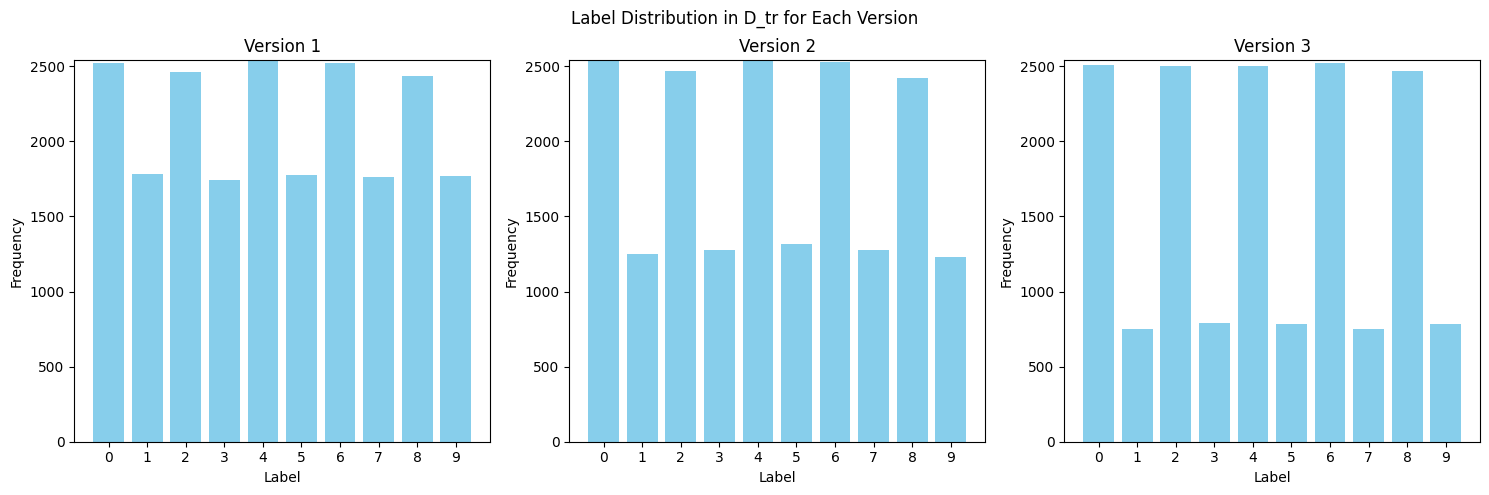

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

num_versions = 3  # 假设有3个版本的增量数据集
num_classes = 10  # CIFAR-10 共有10个类

# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version, base_dir):
    data_path = os.path.join(base_dir, f"D_tr_data_version_{version}.npy")
    labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")
    
    data = torch.load(data_path)
    labels = torch.load(labels_path)
    
    # 验证数据形状和标签范围
    print(f"版本 {version}:")
    print(f"数据形状: {data.shape}, 标签形状: {labels.shape}")
    print(f"标签唯一值: {np.unique(labels)}")
    
    return data, labels

# 验证每个版本 D_tr 的标签分布变化并统一纵坐标
def plot_label_distribution(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(15, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(1, num_versions + 1):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)
        
        # 为了保持 x 轴一致，确保横坐标是从 0 到 9（共10个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值
        
        axs[version - 1].bar(range(num_classes), full_counts, color='skyblue')
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Label")
        axs[version - 1].set_ylabel("Frequency")
        axs[version - 1].set_xticks(range(num_classes))  # 保证横轴一致
        axs[version - 1].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.show()

# 定义数据集的路径
# base_dir_1 = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
# 加载每个版本的 D_tr 并验证其分布
# print("验证 base_dir_1 数据集:")
# plot_label_distribution(base_dir_1)

# 定义数据集的路径
base_dir_2 = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
print("验证 base_dir_2 数据集:")
plot_label_distribution(base_dir_2)


### 2、验证噪声

#### 统计量

In [32]:
import os
import numpy as np
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_replay_samples = 2500  # D_a 包含的样本数


# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    print(f"Loading Original Labels from: {original_labels_path}")
    print(f"Loading Noisy Labels from: {noisy_labels_path}")

    original_labels = torch.load(original_labels_path)
    noisy_labels = torch.load(noisy_labels_path)

    noisy_labels = noisy_labels[num_replay_samples:]  # 剔除重放数据 D_a 的标签部分

    print(f"Loaded Original Labels (first 10): {original_labels[:10]}")
    print(f"Loaded Noisy Labels (first 10): {noisy_labels[:10]}")

    return original_labels, noisy_labels


# 验证噪声效果的通用函数
def verify_noise(base_dir, is_symmetric=True):
    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        print(f"original_labels.shape: {original_labels.shape}")
        print(f"noisy_labels.shape: {noisy_labels.shape}")

        print("Checking Noise...")
        print(f"Verifying Noise for Version {version}")
        noise_mask = original_labels != noisy_labels  # 计算噪声

        noise_count = np.sum(noise_mask)
        print(f"Version {version}: Noise count = {noise_count}")

        if noise_count > 0:
            noisy_samples = original_labels[noise_mask]
            noisy_labels_samples = noisy_labels[noise_mask]
            print(f"Original Labels (first 10 noisy samples): {noisy_samples[:10]}")
            print(f"Noisy Labels (first 10 noisy samples): {noisy_labels_samples[:10]}")

            if not is_symmetric:
                asymmetric_mapping = {
                    0: 2,
                    2: 0,
                    4: 6,
                    6: 4,
                    8: 0,
                }
                for orig_label, noisy_label in zip(noisy_samples, noisy_labels_samples):
                    expected_label = asymmetric_mapping.get(orig_label)
                    if expected_label is not None and noisy_label != expected_label:
                        print(
                            f"Error: Original {orig_label} -> Expected {expected_label}, but got {noisy_label}"
                        )


# 验证对称噪声和非对称噪声效果
print("对称噪声验证：")
verify_noise(base_dir_sym, is_symmetric=True)

print("非对称噪声验证：")
verify_noise(base_dir_asym, is_symmetric=False)

对称噪声验证：
Loading Original Labels from: ../data/cifar-10/gen/nr_0.2_nt_symmetric/D_tr_labels_version_1.npy
Loading Noisy Labels from: ../data/cifar-10/gen/nr_0.2_nt_symmetric/D_tr_labels_version_1.npy
Loaded Original Labels (first 10): tensor([9, 4, 6, 2, 4, 2, 9, 7, 8, 8])
Loaded Noisy Labels (first 10): tensor([5, 8, 8, 1, 7, 7, 0, 8, 4, 4])
original_labels.shape: torch.Size([21317])
noisy_labels.shape: torch.Size([18817])
Checking Noise...
Verifying Noise for Version 1


RuntimeError: The size of tensor a (21317) must match the size of tensor b (18817) at non-singleton dimension 0

#### 小提琴图

Version 1: original_labels size = 25000, noisy_labels size = 21317
Version 2: original_labels size = 25000, noisy_labels size = 18844
Version 3: original_labels size = 25000, noisy_labels size = 16371


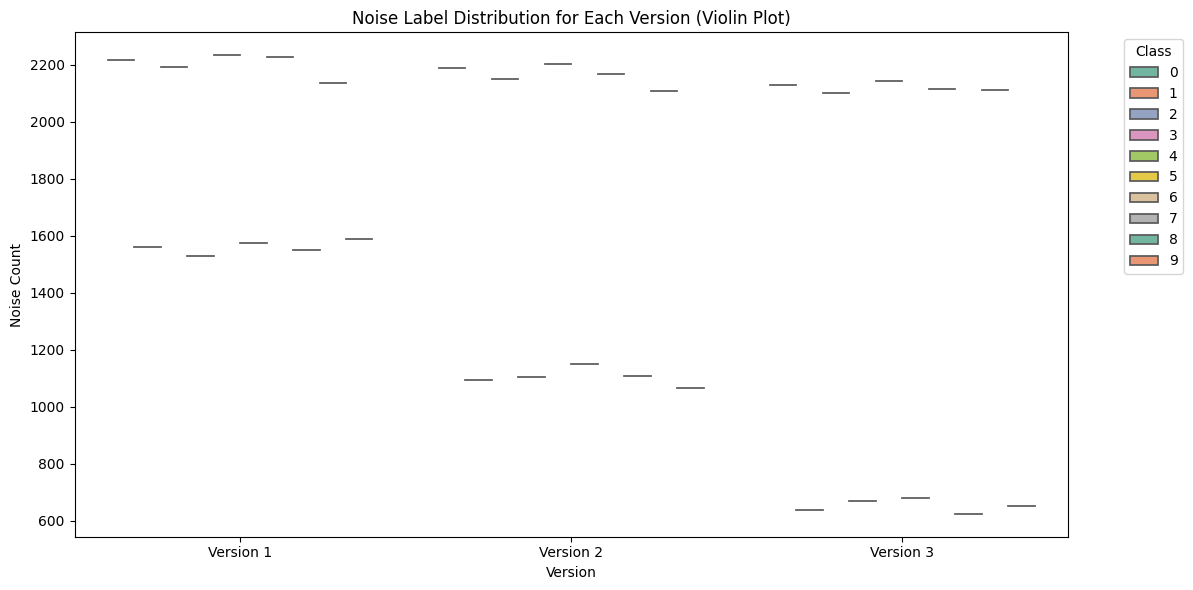

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch  # 添加torch库

num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, "D_inc_0_labels.npy")  # 修正为初始增量标签路径
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 输出标签的形状以进行调试
        print(f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}")

        # 确保 noisy_labels 是一维数组
        if noisy_labels.ndim > 1:
            noisy_labels = noisy_labels.flatten()

        # 确保 noisy_labels 不会超过 original_labels 的长度
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[:len(original_labels)]

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化噪声标签比例的变化，使用小提琴图
def plot_noise_violin(base_dir):
    plt.style.use("default")
    plt.figure(figsize=(12, 6))  # 设置整体图像大小

    all_noise_data = []
    all_classes = []
    all_versions = []

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)
        if original_labels is None or noisy_labels is None:
            continue  # 跳过无法加载的版本

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 对于每个类，计算噪声标签的数量并记录
        for label in range(num_classes):
            noise_per_class = np.sum(noisy_labels_only == label)

            # 记录所有噪声数据、对应的类以及版本
            all_noise_data.append(noise_per_class)  # 直接存储噪声标签数量
            all_classes.append(label)
            all_versions.append(f"Version {version}")

    # 使用Seaborn的小提琴图进行可视化
    sns.violinplot(x=all_versions, y=all_noise_data, hue=all_classes, split=True, inner="quart", palette="Set2")
    plt.title("Noise Label Distribution for Each Version (Violin Plot)")
    plt.xlabel("Version")
    plt.ylabel("Noise Count")
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')  # 添加图例
    plt.tight_layout()
    plt.show()

# 定义数据集的路径
base_dir = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
# 验证并使用小提琴图可视化各版本中的标签噪声分布
plot_noise_violin(base_dir)


#### 条形图

Error loading labels for version 1: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 2: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 3: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'


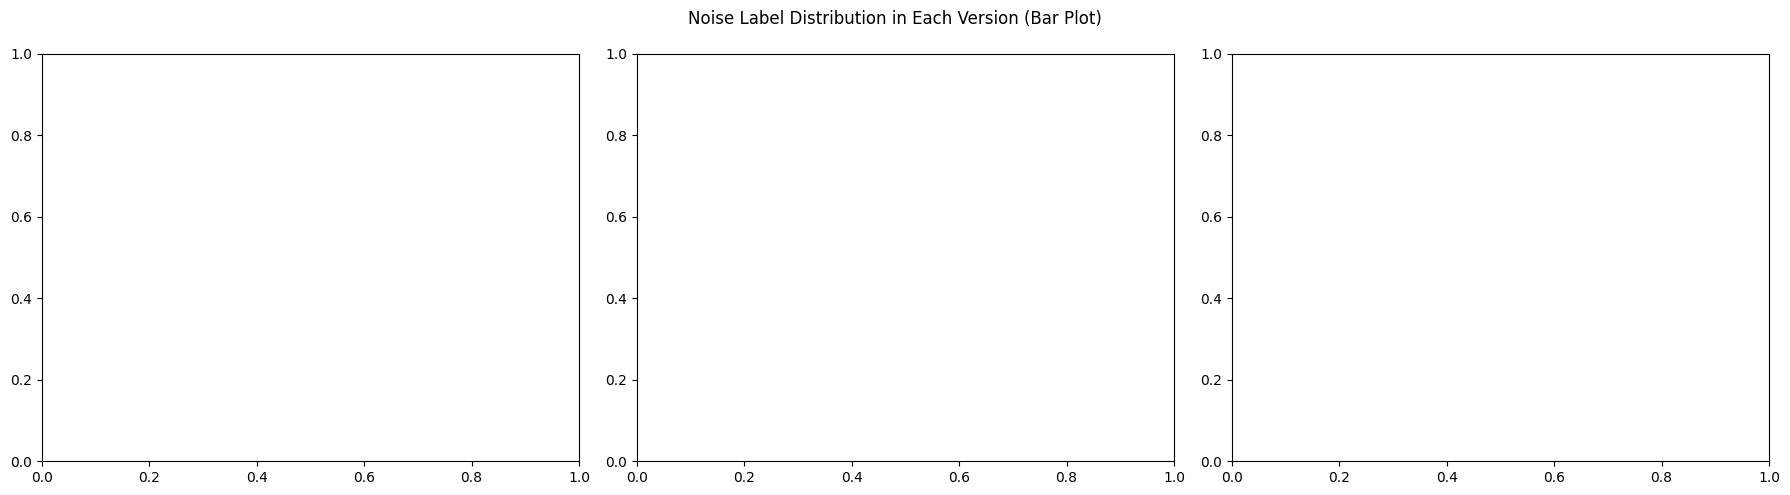

Version 1: original_labels size = 25000, noisy_labels size = 21317
Version 2: original_labels size = 25000, noisy_labels size = 18844
Version 3: original_labels size = 25000, noisy_labels size = 16371


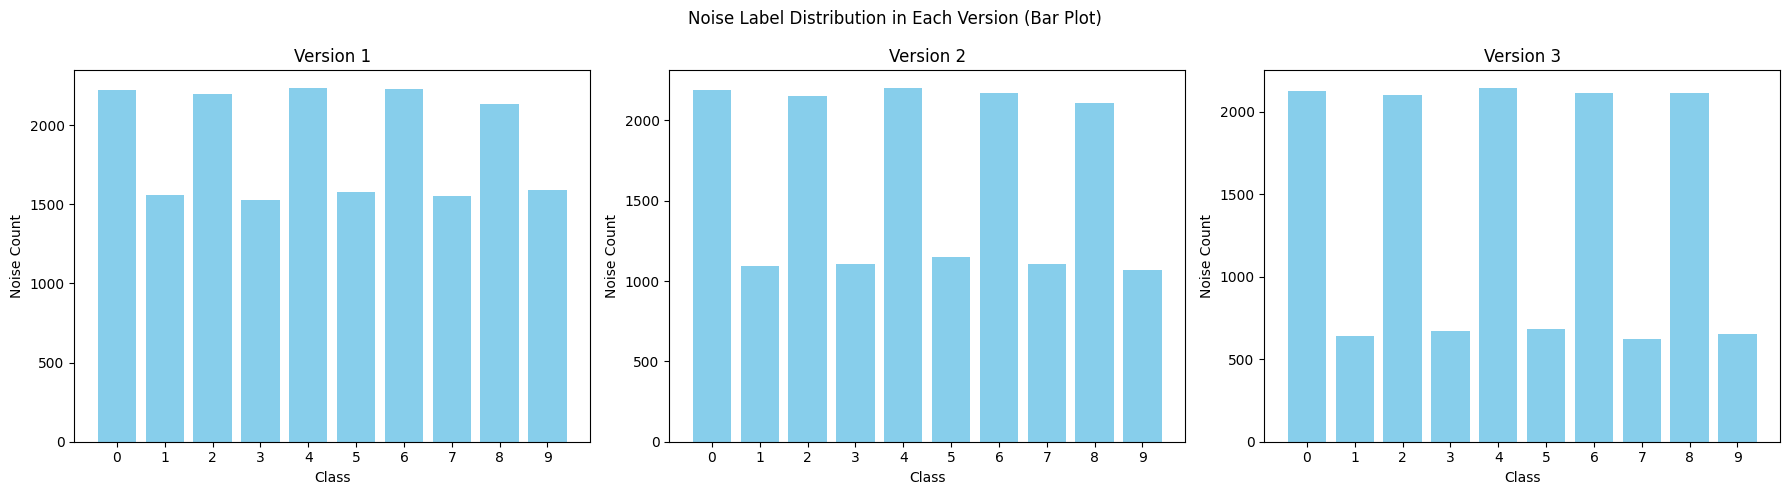

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 定义数据集的路径
base_dir_asym = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_sym = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_inc_0_labels.npy")  # 使用固定的增量标签文件
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(f"Version {version}: original_labels size = {original_labels.size}, noisy_labels size = {noisy_labels.size}")

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始
        
        # 确保 noisy_labels 与 original_labels 大小一致
        if len(noisy_labels) > len(original_labels):
            noisy_labels = noisy_labels[:len(original_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并使用条形图显示噪声标签的分布
def plot_noise_bar(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle("Noise Label Distribution in Each Version (Bar Plot)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 统计噪声标签的数量
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        noisy_labels_only = noisy_labels[noise_mask]

        # 统计每个类的噪声标签数量
        noise_counts = np.zeros(num_classes)
        for label in range(num_classes):
            noise_counts[label] = np.sum(noisy_labels_only == label)

        # 绘制条形图
        axs[version - 1].bar(range(num_classes), noise_counts, color='skyblue')
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Class")
        axs[version - 1].set_ylabel("Noise Count")
        axs[version - 1].set_xticks(range(num_classes))

    plt.tight_layout()
    plt.show()

# 验证并使用条形图可视化各版本中的标签噪声分布
plot_noise_bar(base_dir_asym)
plot_noise_bar(base_dir_sym)


#### 热力图

对称噪声验证：
Version 1: original_labels size = 25000, noisy_labels size = 21317
Mismatch detected in version 1: Adjusting sizes
Version 2: original_labels size = 25000, noisy_labels size = 18844
Mismatch detected in version 2: Adjusting sizes
Version 3: original_labels size = 25000, noisy_labels size = 16371
Mismatch detected in version 3: Adjusting sizes


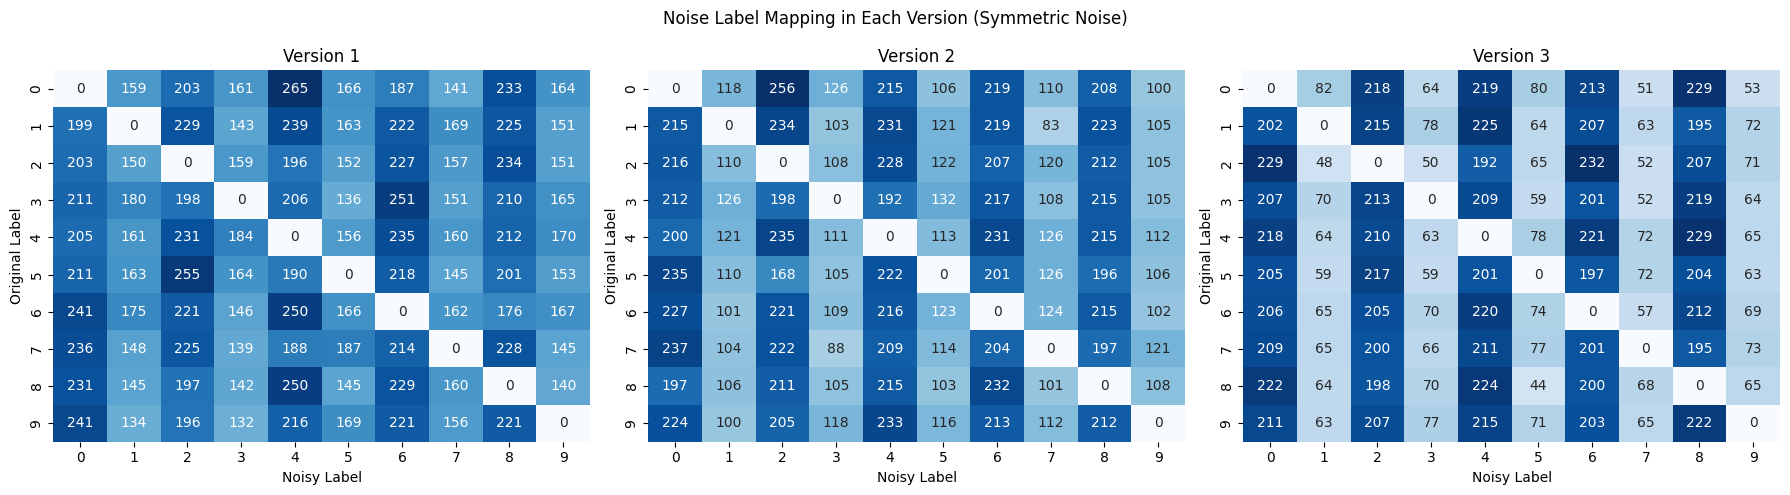

非对称噪声验证：
Error loading labels for version 1: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 2: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'
Error loading labels for version 3: [Errno 2] No such file or directory: '../data/cifar-10/gen/nr_0.2_nt_asymmetric/D_inc_0_labels.npy'


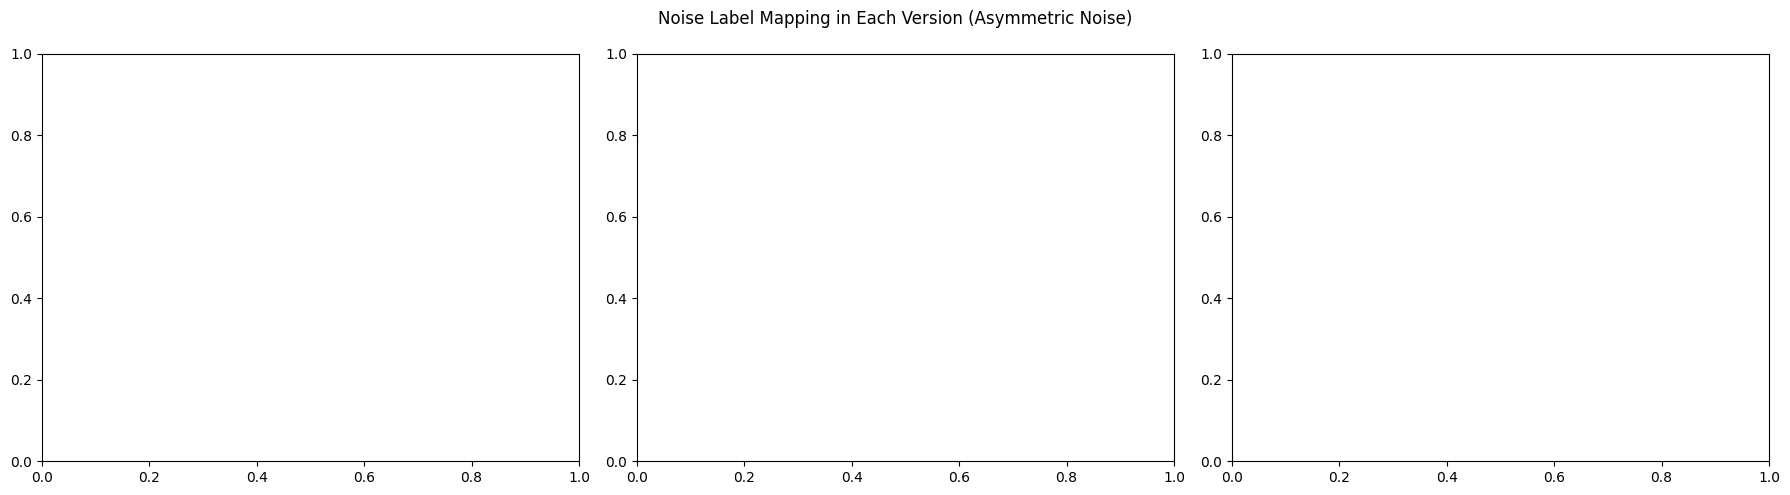

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 定义数据集的路径
base_dir_1 = "../data/cifar-10/gen/nr_0.2_nt_asymmetric"
base_dir_2 = "../data/cifar-10/gen/nr_0.2_nt_symmetric"
num_versions = 3  # 假设有3个增量版本
num_classes = 10  # CIFAR-10 共有10个类
num_replay_samples = 2500  # D_a 包含的样本数

# 加载每个版本的原始标签和噪声标签
def load_labels(version, base_dir):
    original_labels_path = os.path.join(base_dir, f"D_inc_0_labels.npy")  # 固定增量标签文件名
    noisy_labels_path = os.path.join(base_dir, f"D_tr_labels_version_{version}.npy")

    try:
        original_labels = torch.load(original_labels_path).numpy()  # 使用 torch.load 并转换为 numpy
        noisy_labels = torch.load(noisy_labels_path).numpy()

        # 调试输出标签的大小
        print(f"Version {version}: original_labels size = {len(original_labels)}, noisy_labels size = {len(noisy_labels)}")

        # 剔除重放数据 D_a 的标签部分
        noisy_labels = noisy_labels[num_replay_samples:]  # 从增量部分开始
        
        # 确保 noisy_labels 和 original_labels 大小一致
        if len(noisy_labels) != len(original_labels):
            print(f"Mismatch detected in version {version}: Adjusting sizes")
            if len(noisy_labels) > len(original_labels):
                noisy_labels = noisy_labels[:len(original_labels)]
            else:
                original_labels = original_labels[:len(noisy_labels)]

        return original_labels, noisy_labels
    except Exception as e:
        print(f"Error loading labels for version {version}: {e}")
        return None, None

# 计算并可视化对称噪声和非对称噪声的效果
def plot_noise_effect(base_dir, noise_type):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(18, 5))
    fig.suptitle(f"Noise Label Mapping in Each Version ({noise_type} Noise)")

    for version in range(1, num_versions + 1):
        original_labels, noisy_labels = load_labels(version, base_dir)

        if original_labels is None or noisy_labels is None:
            continue  # 如果加载失败，则跳过该版本

        # 找到那些被噪声替换的样本
        noise_mask = (original_labels != noisy_labels)  # 标签不同的部分即为噪声
        original_labels_noisy = original_labels[noise_mask]
        noisy_labels_only = noisy_labels[noise_mask]

        # 构建噪声标签的映射矩阵
        noise_mapping_matrix = np.zeros((num_classes, num_classes))  # 记录每个类的噪声标签分布
        for orig, noisy in zip(original_labels_noisy, noisy_labels_only):
            noise_mapping_matrix[orig, noisy] += 1

        # 绘制热力图展示噪声标签的映射
        sns.heatmap(noise_mapping_matrix, ax=axs[version - 1], cmap="Blues", annot=True, fmt=".0f", cbar=False)
        axs[version - 1].set_title(f"Version {version}")
        axs[version - 1].set_xlabel("Noisy Label")
        axs[version - 1].set_ylabel("Original Label")

    plt.tight_layout()
    plt.show()

# 验证对称噪声效果
print("对称噪声验证：")
plot_noise_effect(base_dir_2, "Symmetric")

# 验证非对称噪声效果
print("非对称噪声验证：")
plot_noise_effect(base_dir_1, "Asymmetric")


# CIFAR-100

### CIFAR-100 数据集构造逻辑

#### 1. 初始数据集划分

- **数据集总量**：CIFAR-100 包含 50,000 个训练样本和 10,000 个测试样本。
- **训练数据集**：记为 $D_{\text{train}} = \{ (x_i, y_i) \mid i = 1, 2, \dots, 50000 \}$，其中 $x_i$ 是图像数据，$y_i$ 是对应的标签。
- **划分方法**：
  - **初始数据集 $D_0$**：从 $D_{\text{train}}$ 中随机抽取 50% 的样本，即 25,000 个样本，作为模型的初始训练数据。
  - **增量数据集 $D_{\text{inc}}$**：剩余的 50% 样本，即 25,000 个样本，作为后续增量学习的数据。

#### 2. 重放数据集 $D_a$

- **构建方式**：从初始数据集 $D_0$ 中随机抽取 10% 的样本，形成重放数据集 $D_a$，该数据集将用于所有增量阶段。
- **样本数量**：$|D_a| = 2,500$ 样本。
- **目的**：重放数据集用于在后续的增量学习过程中，帮助模型保持对早期知识的记忆，防止遗忘。

#### 3. 增量数据集版本 $D_{\text{inc}}^{(t)}$

增量数据集 $D_{\text{inc}}$ 被划分为多个版本，每个版本代表在不同时间点的增量数据。数据集的生成包括两部分：遗忘模拟和噪声注入。

##### 3.1 模拟遗忘

- **目标类别**：CIFAR-100 中的100个类别被分为两个组：遗忘类别和非遗忘类别。
  - **遗忘类别**：从100个类别中选择 20 个类别（例如，每隔5个类别选择一个），这些类别的样本会随着时间推移逐渐减少，以模拟遗忘现象。
  - **保留比例（Retention Ratio）**：设定不同版本的保留比例，以模拟随着时间推移，模型对遗忘类别记忆的逐渐减弱。
    - **第一个增量版本 $D_{\text{inc}}^{(1)}$**：保留 50% 的样本。
    - **第二个增量版本 $D_{\text{inc}}^{(2)}$**：保留 30% 的样本。
    - **第三个增量版本 $D_{\text{inc}}^{(3)}$**：保留 10% 的样本。
- **实现方式**：每个版本从 $D_{\text{inc}}$ 中随机抽取相应比例的遗忘类别样本，构成 $D_{\text{inc}}^{(t)}$。

##### 3.2 噪声注入

- **目标类别**：从非遗忘类别中随机选择一部分类别注入噪声。
  - **噪声类别数量**：每个版本对非遗忘类别中的 20 个类别进行噪声注入，而不是全部 80 个非遗忘类别。
  - **噪声比例**：对于每个版本 $D_{\text{inc}}^{(t)}$，对噪声类别的 10% 样本注入噪声，模拟标签扰动。
  - **噪声注入过程**：
    - 随机选择噪声类别的部分样本。
    - 将这些样本的标签随机替换为其他类别标签，模拟现实中可能存在的数据标签错误或干扰。
  - **递减噪声比例**：随着增量版本的变化，噪声比例逐渐减少，以模拟更真实的噪声变化场景。
    - **版本1**：30% 非遗忘类别的 10% 样本被注入噪声。
    - **版本2**：20% 非遗忘类别的 10% 样本被注入噪声。
    - **版本3**：10% 非遗忘类别的 5% 样本被注入噪声。

#### 4. 组合训练数据集 $D_{\text{tr}}^{(t)}$

- **组合方式**：将重放数据集 $D_a$ 与当前增量版本 $D_{\text{inc}}^{(t)}$ 合并，形成训练数据集 $D_{\text{tr}}^{(t)}$。
- **公式表示**：
  
  $$ D_{\text{tr}}^{(t)} = D_a \cup D_{\text{inc}}^{(t)} $$

  其中，$D_a$ 保持固定，$D_{\text{inc}}^{(t)}$ 随时间版本的不同而变化。
- **样本数量**：
  - $D_{\text{tr}}^{(1)}$：2,500 + 12,500 = 15,000
  - $D_{\text{tr}}^{(2)}$：2,500 + 7,500 = 10,000
  - $D_{\text{tr}}^{(3)}$：2,500 + 2,500 = 5,000

#### 5. 保存与使用

- **数据保存**：每个版本的训练数据集 $D_{\text{tr}}^{(t)}$ 分别保存为独立的 `.npy` 文件，便于后续的增量学习实验使用。
  - 数据部分：`cifar100_D_tr_data_version_{t}.npy`
  - 标签部分：`cifar100_D_tr_labels_version_{t}.npy`
- **测试数据集**：保持不变，作为模型性能评估的标准。

#### 6. 总结

- **动态性**：每个版本的训练数据集不仅包含固定的重放数据，还包含随时间变化的增量数据，模拟了真实世界中数据不断涌入的情况。
- **挑战性**：通过模拟遗忘和噪声注入，使得模型在学习过程中面临记忆保持和抗噪能力的挑战，有助于评估增量学习算法的鲁棒性和有效性。
- **结构清晰**：数据集构造过程步骤明确，版本划分合理，便于系统化地进行增量学习实验。

### 最终数据集结构

- **重放数据集**：固定的 $D_a$（2,500 个样本）。
- **增量版本数据集**：
  - $D_{\text{tr}}^{(1)} = D_a \cup D_{\text{inc}}^{(1)}$，总计 15,000 个样本（2,500 + 12,500）。
  - $D_{\text{tr}}^{(2)} = D_a \cup D_{\text{inc}}^{(2)}$，总计 10,000 个样本（2,500 + 7,500）。
  - $D_{\text{tr}}^{(3)} = D_a \cup D_{\text{inc}}^{(3)}$，总计 5,000 个样本（2,500 + 2,500）。

每个版本的数据集独立保存为 `.npy` 文件，便于在增量学习过程中按版本加载和使用。

---

### 关键要点

1. **噪声分布合理性**：通过选择部分类别注入噪声，并且在不同增量版本中递减噪声比例，确保噪声的影响适中，避免噪声影响过大。
2. **遗忘模拟**：通过减少遗忘类别样本的保留比例，逐步加大模型面临的遗忘挑战。
3. **重放机制**：通过固定重放数据集，减缓灾难性遗忘，模拟现实中的长期记忆保持需求。
4. **可扩展性**：该设计具有灵活的噪声注入和版本化管理方案，适合多种增量学习算法的实验和评估。


## 验证

### 验证遗忘

### 验证噪声

### 验证遗忘+噪声